In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.sparse import hstack, vstack, coo_matrix, csr_matrix, bmat
sns.set_style("darkgrid")
data_path = "data/"

/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Model building

In order to give better reccomendations to travellers, the price point of a shop or restaurant is essential. A student, living of a part time job has a different budget than the business traveler. Thus, if you often visit cheap eats you'll likely love the areas at your destination that serve streetfood and the like, while the guy putting down the company card will have no qualms about having an expensive meal. 

In this section a model to predict prices will be built. The model will be based on the following features:
- Bag of Words or TF-IDF features
- Raw review length
- Lix number [see here](https://en.wikipedia.org/wiki/Lix_(readability_test))
- Sentiment score (VADER)

First of all, the reviews will be used to predict the price of the reviewed place. Either a bag of words count or a TF-IDF will be used, with the thesis that TF-IDF will perform better. The BoW count simply tells how any times a word is used in a review where TF-IDF show the relative importance of a given word in the review, taking into account all reviews.  

Secondly the length of the review is thought to influence the price in some way. It can be argued that it could affect both negatively and positively as long reviews tend to be either very positive or negative.

The LIX number is an index that indicates readability of a text. It provides a number from zero and up (though likely below 100), which indicates how hard the text is to understand. It follows that below 25 are kids books and 35 to 45 is around the level of most newspapers. Above 55 is usually reserved for hard academic papers. The thesis is that more eloquent reviews might lead to a higher price. 

Finally, the sentiment score is calculated using the VADER (Valence Aware Dictionary and sEntiment Reasoner) framework. This is a popular and powerful framework for performing sentiment analysis and provides three values for a given text. The degree to which the text is positive, negative and neutral. 

---

First, the preprocessed NLP data is loaded and prepared for analysis.

In [2]:
df = pd.read_csv("data/NLP_data.csv")
df['reviewTextClean'] = df['reviewTextClean'].str.lower()
df.dropna(subset=["reviewTextClean"], inplace=True)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow_counts = count_vect.fit_transform(df['reviewTextClean'].values)

In [4]:
print("Length of vocabulary:", len(count_vect.vocabulary_))
print("Length of corpus:", bow_counts.shape[0])

Length of vocabulary: 22973
Length of corpus: 34923


Create tf-idf representation of `reviewTextClean`

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
bow_tfidf = tfidf.fit_transform(bow_counts)

Add remaining features to both bow_counts and bow_tfidf. Here, both LIX and Number of Words are fitted such that they take values between zero and one to match the scale of the TF-IDF. This is done using min-max scaling. 

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[["LIXNorm", "NoWNorm"]] = scaler.fit_transform(df[["LIX", "NumberOfWords"]])

In [7]:
df["price"] = df["price"].astype(int)

The neutral sentiment score is not added as a feature. It would be heavily correlated with the positive and negative sentiment scores, since the three sum to one. 

In [8]:
rem_feats = csr_matrix(df[["posReviewPercent", "negReviewPercent", "LIXNorm", "NoWNorm"]])
bow_counts_full = hstack([bow_counts, rem_feats]).tocsr()
bow_tfidf_full = hstack([bow_tfidf, rem_feats]).tocsr()

In [11]:
print(bow_tfidf_full[0,:])

  (0, 833)	0.27686248133942865
  (0, 1711)	0.10706632712216521
  (0, 4145)	0.2805525408883
  (0, 4915)	0.28437346494788585
  (0, 5220)	0.17050978277327358
  (0, 5569)	0.245156415110424
  (0, 6386)	0.10456978984058643
  (0, 7905)	0.15832874300150368
  (0, 8810)	0.06858585623849757
  (0, 8984)	0.06956063293257063
  (0, 9893)	0.3613211781160347
  (0, 11461)	0.14552646615429896
  (0, 11888)	0.1291489010931754
  (0, 13556)	0.1348788956990392
  (0, 13642)	0.09733546247922713
  (0, 17947)	0.16555346954485092
  (0, 19044)	0.20771534105026906
  (0, 19341)	0.09886157163166752
  (0, 20570)	0.12823857290505988
  (0, 20684)	0.28038263916013517
  (0, 21176)	0.16158268183912652
  (0, 21306)	0.24402847754314622
  (0, 21710)	0.254530635282915
  (0, 22208)	0.15807811848693062
  (0, 22718)	0.2658723650343767
  (0, 22973)	0.141
  (0, 22974)	0.109
  (0, 22975)	0.1362741594039535
  (0, 22976)	0.06657608695652173


First the data is split into training and test. In this case, to keep a completely clean test set, two splits are made. First we split the data into a developement set and a test set. This test set is set aside for final testing once the models has been tuned. The developement set is then split into train and validation such that one can train and test a model as usual. This is done for both the bag of words set and the TF-IDF set in order to test the hypothesis that a TF-IDF performs better than a simple bag of words count. 

In [12]:
from sklearn.model_selection import train_test_split
y = df.price.values-1
text= np.array(df['reviewText'])

# Split into development and test split for bow and tfidf only
X_bow_dev, X_bow_test, X_tfidf_dev, X_tfidf_test, X_tfidf_f_dev, X_tfidf_f_test, y_dev, y_test, text_dev, text_test = train_test_split(bow_counts, bow_tfidf, bow_tfidf_full,  y, text, test_size=0.2, stratify=y)

# Split development into training and validation for bow and tfidf only
X_bow_train, X_bow_val, X_tfidf_train, X_tfidf_val, X_tfidf_f_train, X_tfidf_f_val, y_train, y_val, text_train, text_val = train_test_split(X_bow_dev, X_tfidf_dev, X_tfidf_f_dev, y_dev, text_dev, test_size=0.1, stratify=y_dev)

In [13]:
# Function that returns performance of classifier 
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
def classification_metrics(header_text, clf, X_train, X_test, y_train, y_test):
    print("="*35)
    print(" "*int((35-len(header_text))/2), header_text)
    print("="*35)
    y_pred = clf.predict(X_train)
    print("Train Accuracy:", accuracy_score(y_train, y_pred))
    y_pred = clf.predict(X_test)
    print("Val Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
    print(confusion_matrix(y_test, y_pred))

First a simple dummy classifier was tested using the bag of word counts. It predicts the class of the observation from the most frequent class in the set. This performs about as well as expected with a accuracy of 55.82% for both training and validation. This is also the case when adding the additional features as the most frequent class in the observed y does not change with additional features.

In [14]:
# Dummy classifier predicting most frequent class
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_bow_train, y_train)
y_pred = dummy.predict(X_bow_val)
classification_metrics("Dummy classifier", dummy, X_bow_train, X_bow_val, y_train, y_val)

          Dummy classifier
Train Accuracy: 0.5604120267260579
Val Accuracy: 0.560486757337151
F1 Score: 0.402624890821091
[[   0  496    0]
 [   0 1566    0]
 [   0  732    0]]


From the dummy classifier, the next step to test was the TF-IDF data. This was done using a logistic regression as that provides a discrete outcome. This performs significantly better than the dummy classifier with an accuracy of 65% on the validation set. When adding the extra features troubles arise

In [15]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="saga")
lr.fit(X_tfidf_train, y_train)
classification_metrics("LogisticRegression tf-idf", lr, X_tfidf_train, X_tfidf_val, y_train, y_val)

      LogisticRegression tf-idf
Train Accuracy: 0.741250397709195
Val Accuracy: 0.6335003579098067
F1 Score: 0.6052754694770959
[[ 138  340   18]
 [  62 1337  167]
 [   7  430  295]]


In [16]:
lr = LogisticRegression(solver="saga")
lr.fit(X_tfidf_f_train, y_train)
classification_metrics("LogisticRegression tf-idf full", lr, X_tfidf_f_train, X_tfidf_f_val, y_train, y_val)

   LogisticRegression tf-idf full
Train Accuracy: 0.7405742920776328
Val Accuracy: 0.6342161775232641
F1 Score: 0.6060167955356105
[[ 140  339   17]
 [  61 1339  166]
 [   7  432  293]]


Then xgboost is employed to see what a Gradient Boosting can do to classify the price points of the establishments. This does not perform better than the logistic regression.

In [17]:
import xgboost
xgb = xgboost.XGBClassifier(eval_metric="mlogloss", use_label_encoder=False)
xgb.fit(X_tfidf_train, y_train)
classification_metrics("XGBoost tf-idf", xgb, X_tfidf_train, X_tfidf_val, y_train, y_val)

           XGBoost tf-idf
Train Accuracy: 0.7305520203627108
Val Accuracy: 0.6206156048675734
F1 Score: 0.5691209137602626
[[ 108  376   12]
 [  46 1429   91]
 [   0  535  197]]


In [18]:
xgb.fit(X_tfidf_f_train, y_train)
classification_metrics("XGBoost tf-idf full", xgb, X_tfidf_f_train, X_tfidf_f_val, y_train, y_val)

         XGBoost tf-idf full
Train Accuracy: 0.7326996500159084
Val Accuracy: 0.6220472440944882
F1 Score: 0.5686475813303657
[[ 106  380   10]
 [  36 1439   91]
 [   1  538  193]]


Finally, as the Logistic regression seems to perform the best, an Ordinal Logistic Regression is tested. This could be useful as there is an inherent order to the price points in the sense that `$$` is more expensive than `$` etc. (`$` < `$$` < `$$$`) 

In [19]:
from mord import LogisticAT
from sklearn.preprocessing import StandardScaler
# y must be integer - fixed in df 
#y_train = np.array([int(i) for i in y_train])
scaler = StandardScaler(with_mean=False)
X_tfidf_train = scaler.fit_transform(X_tfidf_train)
lat = LogisticAT(alpha=1.0, verbose=0)
lat.fit(X_tfidf_train, y_train)
classification_metrics("Ordinal Logistic Regression tf-idf", lat, X_tfidf_train, X_tfidf_val, y_train, y_val)

 Ordinal Logistic Regression tf-idf
Train Accuracy: 0.8730909958638243
Val Accuracy: 0.560486757337151
F1 Score: 0.402624890821091
[[   0  496    0]
 [   0 1566    0]
 [   0  732    0]]


In [20]:
X_tfidf_f_train = scaler.fit_transform(X_tfidf_f_train)
lat.fit(X_tfidf_f_train, y_train)
classification_metrics("Ordinal Logistic Regression tf-idf full", lat, X_tfidf_f_train, X_tfidf_f_val, y_train, y_val)

 Ordinal Logistic Regression tf-idf full
Train Accuracy: 0.8726137448297805
Val Accuracy: 0.560486757337151
F1 Score: 0.402624890821091
[[   0  496    0]
 [   0 1566    0]
 [   0  732    0]]


As ordinal regression (as well as dummy and xgboost) performs significantly worse than the logistic regression, the logistic regression is chosen to be tuned in order to increase performance. This is done through a grid search to tune the hyperparameters.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform

# As the goal is to classify, the RepeatedStratifiedKFold is used
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

space = dict()
space['solver'] = ['saga']
space['penalty'] = ['none', 'l1', 'l2']
space['C'] = [0.1, 1, 10]

search = GridSearchCV(lr, space, cv=cv)
result = search.fit(X_tfidf_f_train, y_train)

Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which m

The found hyperparameters can be seen below, and will be used for predicting the price points of the full data set.

In [ ]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

## predicting the price for all business
Using the best prediction model on the remaining of the businesses without a price range 

In [21]:
df_predict = pd.read_csv("data/NLP_predict.csv")
df_predict['reviewTextClean'] = df_predict['reviewTextClean'].str.lower()
df_predict.dropna(subset=["reviewTextClean"], inplace=True)

In [22]:
bow_counts_final = count_vect.transform(df_predict['reviewTextClean'].values)

Create tf-idf representation of `reviewTextClean`

In [23]:
bow_tfidf_final = tfidf.transform(bow_counts_final)

Add remaining features to both bow_counts and bow_tfidf. Here, both LIX and Number of Words are fitted such that they take values between zero and one to match the scale of the TF-IDF. This is done using min-max scaling. 

In [24]:
scaler_f = MinMaxScaler()
df_predict[["LIXNorm", "NoWNorm"]] = scaler_f.fit_transform(df_predict[["LIX", "NumberOfWords"]])

The neutral sentiment score is not added as a feature. It would be heavily correlated with the positive and negative sentiment scores, since the three sum to one. 

In [25]:
rem_feats_pred = csr_matrix(df_predict[["posReviewPercent", "negReviewPercent", "LIXNorm", "NoWNorm"]])
bow_counts_final = hstack([bow_counts_final, rem_feats_pred]).tocsr()
bow_tfidf_final = hstack([bow_tfidf_final, rem_feats_pred]).tocsr()

In [26]:
X = bow_tfidf_final
predict = lr.predict(X)
# Get prices back to 1-2-3 format instead of 0-1-2
df_predict["pred_price"] = predict+1

In [27]:
# Fraction that matches real price, 
# all prices in the NPL predict dataframe are NaN so the fraction should be 0
sum(sum([df_predict["price"] == df_predict["pred_price"]])) / len(df_predict)

0.0

In [28]:
# First create a series with the Id, predicted price and the counts
p_choice = df_predict.groupby(['gPlusPlaceId', 'pred_price']).size()

# Create dataframe
df_p = p_choice.to_frame('count').reset_index()
# Find largest count for each place Id
df_pmax = df_p.groupby('gPlusPlaceId').max()['count'].reset_index()
# Merge the largest count and the df with the price points
df_pfin = df_pmax.merge(df_p, on=['gPlusPlaceId', 'count'])
# Drop the counts
df_pfin = df_pfin.drop(['count'], axis=1)

# As there are cases where there are equal number of reviews, these cases pick the larger price
df_pfin = df_pfin.groupby('gPlusPlaceId').max()['pred_price'].reset_index()

## saving the data

Finally, the prices are added to the places data, such that every establishment has a price associated with it.

In [30]:
df_places = pd.read_csv("data/places_final.csv")
df_places = pd.merge(df_places, df_pfin, how="left", on="gPlusPlaceId")
df_places.head()

,gPlusPlaceId,name,price,lat,lon,city,address,Grid,category,pred_price
0,101742583391038750118,Carpo London,NaN,51.509499,-0.135762,London,"16 Piccadilly, London W1J 0DE, United Kingdom",L159,Retail,2.0
1,100574642292837870712,Premium Cars,NaN,51.514637,-0.064980,London,"10 Commercial Road Premium Cars First Floor, S...",L186,Other,NaN
2,105185983265572241970,eSpares Ltd,NaN,51.479416,-0.179209,London,"Chelsea Wharf, 15 Lots Rd, London, Chelsea SW1...",L40,Wholesale,2.0
3,104500852703501308358,Superdrug,NaN,51.494537,-0.145769,London,"Unit 35, Victoria Railway Station, London SW1V...",L101,Retail,NaN
4,107519298595557659572,Kura,2.0,51.502122,-0.163029,London,"3-4 Park Close, London SW1X 7PQ, United Kingdom",L137,Restaurant,NaN


In [33]:
price = np.zeros(len(df_places))
for i in range(len(df_places)):
    if np.isnan(df_places['price'][i]) and np.isnan(df_places['pred_price'][i]):
        price[i]=np.nan
    elif np.isnan(df_places['price'][i]):
        price[i]=df_places['pred_price'][i]
    elif np.isnan(df_places['pred_price'][i]):
        price[i]=df_places['price'][i]
    else:
        price[i]= df_places['price'][i]

df_places['price']=price

As there are bunisses that do not have any reviews in the review data, it will not be possible to predict a price for these.

In [39]:
print('Fraction of the business without a pricerange: ',np.round(len(np.where(np.isnan(df_places['price']))[0])/len(df_places),4))

Fraction of the business without a pricerange:  0.2622


In [41]:
df_places=df_places.drop(['pred_price'], axis=1)

In [42]:
df_places.to_csv(data_path + "places_final_NLP.csv", index=False)

## Model Interpretation

In order to explore what features has the biggest influence on the price predictions the overall feature importance the the best prediction model are computed. Furthermore, a SHAP analysis will be conducted to inspect the most important features in the dataset, and for a few selected reviews. 

In [43]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
import shap
from random import sample
import random
%matplotlib inline
FIG_SIZE = (40,18)
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize': FIG_SIZE})
matplotlib.rcParams['figure.figsize'] = FIG_SIZE
plt.rcParams['figure.figsize'] = FIG_SIZE

Defining helper function s to calculate feature importance for the regression model

In [44]:
#Calculating feature imporatnce
def imp_df(column_names, importances):
    """Function for creating a feature importance dataframe"""
    df = pd.DataFrame({'feature': column_names, 'feature_importance': importances})\
           .sort_values('feature_importance', ascending=False)\
           .reset_index(drop=True)
    return df

# plotting feature importance
def var_imp_plot(imp_df, title):
    """Plotting a feature importance dataframe (horizontal barchart)"""
    sns.barplot(x='feature_importance', y='feature', data=imp_df, 
                orient='h', color='royalblue')\
       .set_title(title, fontsize = 20)

As the data is on a sparse format, the feature names map are extracted from the vector count. Hereafter the 4 additional features for the review `sensitivit`, `LIX number` and `number of words` are appended

In [45]:
feature_names = count_vect.get_feature_names()
feature_names.extend(["posReviewPercent", "negReviewPercent", "LIXNorm", "NoWNorm"])

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


Creating a datafram for the X train data for tf-idf full training data, and adding the feature names for the columns

In [46]:
X = pd.DataFrame.sparse.from_spmatrix(X_tfidf_f_train, columns=feature_names)

Finding the feature impartance from the linear regression coefficients for all features. 

As the logistic regression model predict 3 values, `$`, `$$`and `$$` respectivly, we have chosen to analyse which featues the the biggest influence on the expensive estblishments.

In [47]:
lr_imp = imp_df(X.columns, lr.coef_[2]) # predictions in price class 2

To decrease the number of features considers, the 15 features with the highest positiv and the 15 feature with the most negative imporatance score are visualised

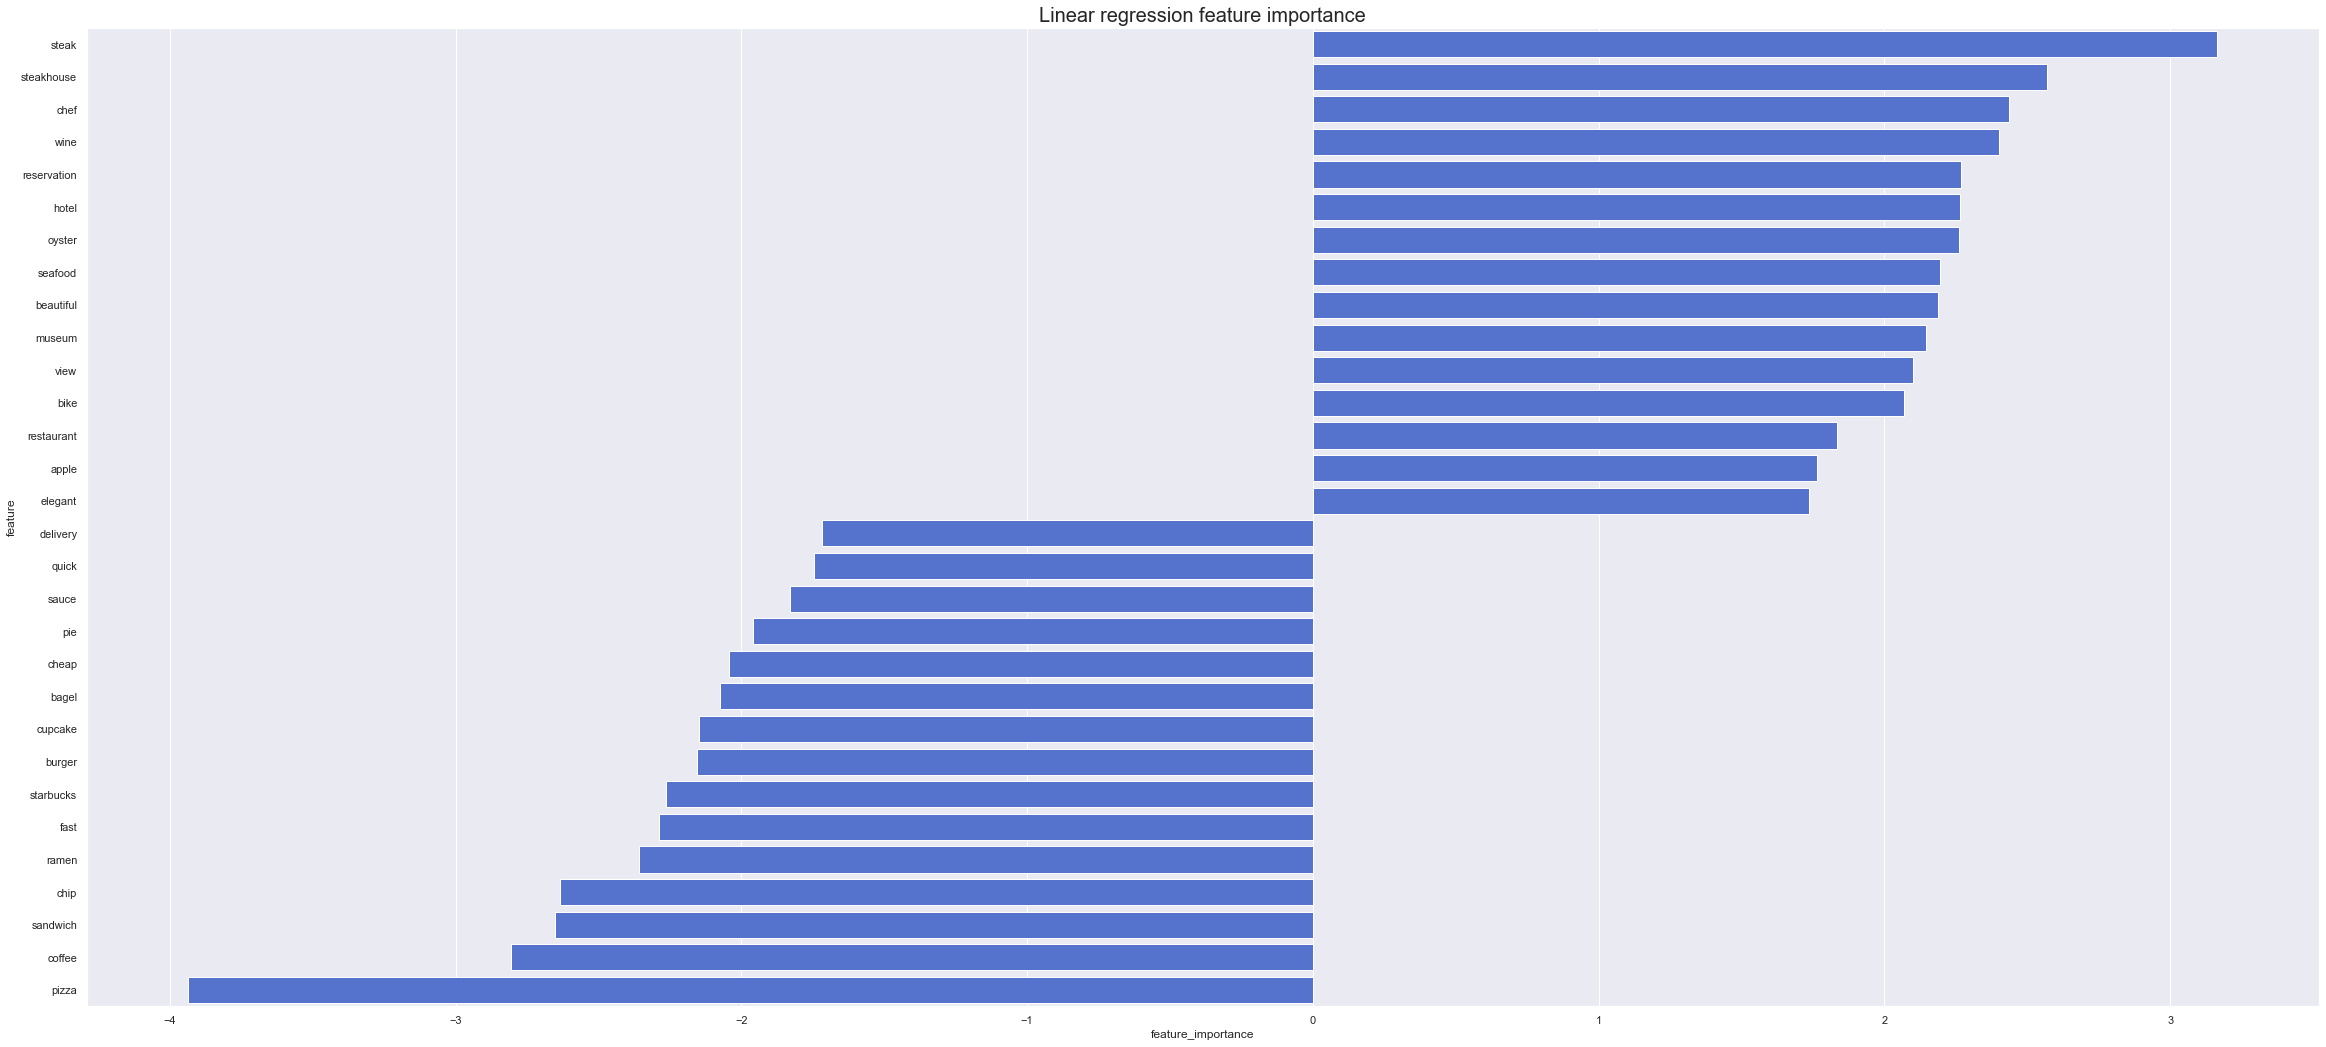

In [48]:
importance_30 = lr_imp[:15].append(lr_imp[-15:], ignore_index=True)
var_imp_plot(importance_30, 'Linear regression feature importance')

From above plot, it can be derived that words like: *Steak*, *View*, *Reservation* and *Oyster* have a positive effect on the price prediction if they appear in a review. Whereas words like *Pizza*, *Coffee*, *Sandwich* and *Fast* are likely to have a negative effect on the price preduction, meaning that the price will generally be predicted lower if these words appear in a review. 

The above plot also indicated the the LIX number, number of words and sensitivity of a review generally are not the most important features when predicting the price range of a business

#### SHAP analysis

To investigate the feature importance for the entire dataset a SHAP analyses is carried out. From this we hope to be able to outline whe most important features on an aggregated level. 

To minimize the run time of the SHAP analysis, a random sample with size = 5000 is taken from the sparsed X_train data

In [49]:
all_indices = range(X_tfidf_f_train.shape[0])
random_indices = random.sample(all_indices, 2000)

sorted_random_indices = sorted(random_indices)
X_sample=X_tfidf_f_train[sorted_random_indices, :]

In [50]:
explainer = shap.Explainer(lr, X_tfidf_f_train, feature_names=count_vect.get_feature_names())

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [51]:
#finding the shap_values for the n=2000 random samples
shap_values = explainer(X_sample)

When visualising the Sresults of the SHAP explainer s negative shap value inducated that a feature or a word appearing makes the classifyer less likely to predict an esablishment as exopensive, where a positive shap value indicated high chance of preducting the price class

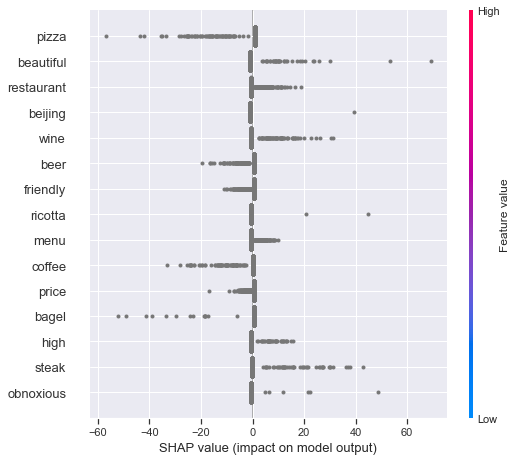

In [52]:
# SHAP beeswarm plot
shap.summary_plot(shap_values[:,:,2],feature_names=count_vect.get_feature_names(),max_display=15) 
#max display can be larger if the fig size is adjusted

Not surprisingly the beeswarm plpt of the SHAP values indicated that some of the most important features are similar to the once the feature importance plot shows. But as the SHAP analysis is made from all price classes there are additional features that are included. 
This could also be due to the limited sample the SHAP analyses is based on rather than the full dataset. 

**Test to see feature importance for prediction where the exact pricerange was predicted and some where the prediction is wrong**

In [53]:
y_pred=lr.predict(X_tfidf_f_train)

In [54]:
#Checking review number 999
test_review=999
x_index=sorted_random_indices[test_review]
text_train[x_index]

"Had a meal with my son and daughter on the way to an Arsenal match.  The place was packed, but other patrons were happy to make room and squeeze us in at a table.  The service was surprisingly good on such a busy day.  Our order was taken promptly, and the food didn't take long at all.  As far as pub food goes, it was pretty tasty and there was plenty of it.  Bar staff were very efficient, and even though busy were willing to help a tourist pick a good beer."

In [55]:
print('Actual price range of review: ', y_train[x_index])
print('Predicted price range of review: ',y_pred[x_index])

Actual price range of review:  0
Predicted price range of review:  0


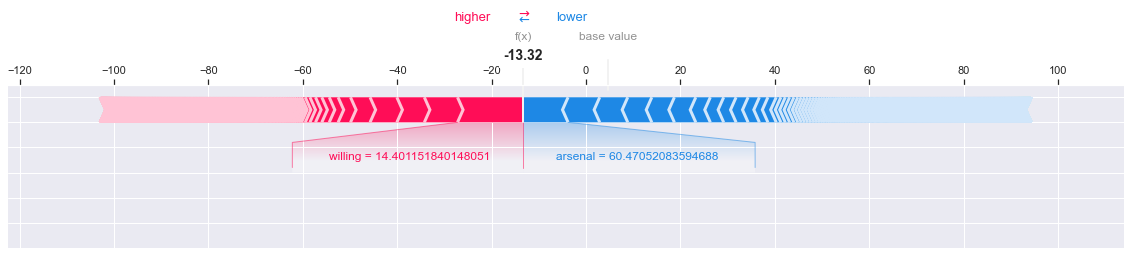

In [56]:
shap.force_plot(explainer.expected_value[2], shap_values[test_review,:,2].values, 
                X.iloc[x_index,:], 
                matplotlib=True)

In [57]:
# checking review number 562
test_review=562
x_index=sorted_random_indices[test_review]
text_train[x_index]

'OK, the Times Square location is better for atmosphere.'

In [58]:
print('Actual price range of review: ', y_train[x_index])
print('Predicted price range of review: ',y_pred[x_index])

Actual price range of review:  1
Predicted price range of review:  0


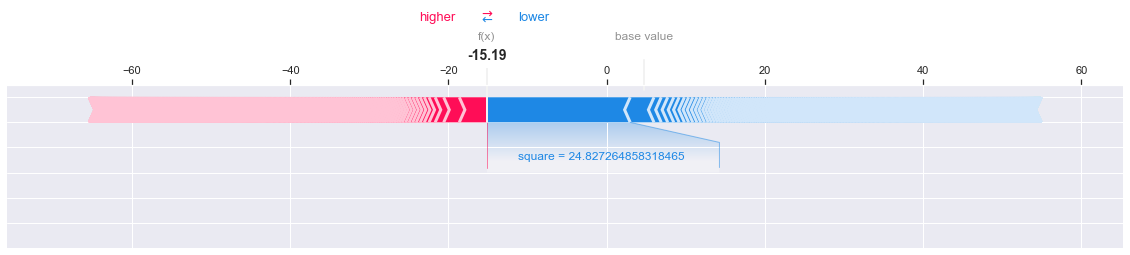

In [59]:
shap.force_plot(explainer.expected_value[2], shap_values[test_review,:,2].values, 
                X.iloc[x_index,:], 
                matplotlib=True)

In [60]:
# checking review number 1390
test_review=1390
x_index=sorted_random_indices[test_review]
text_train[x_index]

"This place is just like every other Cosi, really busy and crazy during lunch time. I usually take a late lunch so I'll stop in for my sandwich around 2. The food is just the same as the other locations. If you're in need of a quick healthy bite for lunch this is the place to go. The people are always nice and the place is always clean. Can't complain at all about this location."

In [61]:
print('Actual price range of review: ', y_train[x_index])
print('Predicted price range of review: ',y_pred[x_index])

Actual price range of review:  0
Predicted price range of review:  0


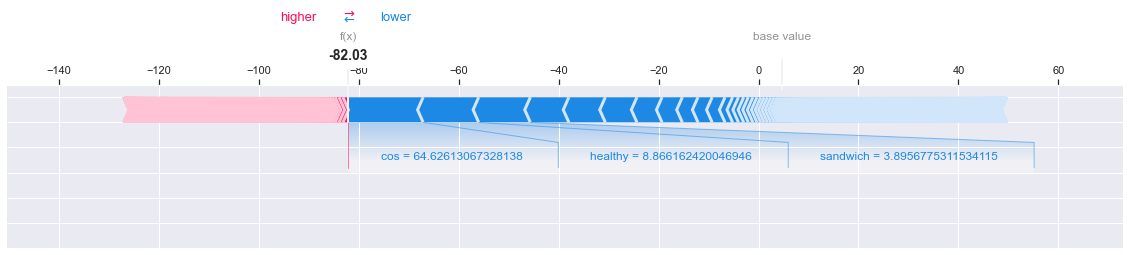

In [62]:
shap.force_plot(explainer.expected_value[2], shap_values[test_review,:,2].values, 
                X.iloc[x_index,:], 
                matplotlib=True)